## 🎯 Objetivo
##### Entrenar un modelo de predicción de calorías quemadas por sesión para cada uno de los 5 clusters que obtuviste con KMeans. Esto nos permite que cada modelo se adapte al perfil de usuario representado en su cluster, mejorando la precisión respecto a usar un solo modelo general.

### Paso 1. Cargar dataset con los clusters asignados

* __train_test_split__ divide los datos en entrenamiento y prueba.

* __LinearRegression__ y __RandomForestRegressor__ son los modelos a comparar.

* __mean_squared_error__ y __r2_score__ son métricas para evaluar los resultados.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Cargar el dataset que ya incluye los clusters
dataset = pd.read_csv("dataset_con_clusters.csv")
print(dataset.columns)


Index(['id', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM',
       'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Workout_Cardio', 'Workout_HIIT', 'Workout_Strength', 'Workout_Yoga',
       'cluster'],
      dtype='object')


Este dataset es igual que el anterior, pero incluye una columna con el número de cluster (0 a 4) asignado a cada sesión. Esa columna se generó con KMeans y representa el grupo al que pertenece cada sesión de entrenamiento, según características físicas.

### Paso 2: Seleccionar variables para la predicción
Aquí vamos a seleccionar como variable objetivo: Calories_Burned, y como variables predictoras todas excepto el ID, Calories_Burned y el cluster.


In [2]:
# Variable objetivo
target = "Calories_Burned"

# Variables predictoras (exceptuamos ID, cluster y variable objetivo)
excluded = ["ID", "Calories_Burned", "cluster"]
features = [col for col in dataset.columns if col not in excluded]

* __target__ es la columna que queremos predecir: las calorías quemadas.

* __fuatures__ contiene el resto de variables, excluyendo calorias, cluster e id

### Paso 3: Entrenar un modelo para cada cluster

Por cada cluster (de 0 a 4), filtramos el dataset, separamos en entrenamiento y prueba, escalamos los datos y entrenamos un modelo. Aquí usaremos GradientBoostingRegressor, pero puedes hacerlo con varios.

In [5]:


# Diccionario para guardar resultados y modelos por cluster
resultados_cluster = {}
modelos_cluster = {}
print("\nR² Score: mide qué tanto del valor de y se puede explicar con X (ideal cercano a 1).\nRMSE: mide el error promedio entre las predicciones y los valores reales (más bajo = mejor).")

for k in sorted(dataset["cluster"].unique()):
    print(f"\n--- Cluster {k} ---")

    dataset_k = dataset[dataset["cluster"] == k]

    X = dataset_k[features]
    y = dataset_k[target]

    # División en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modelo
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Evaluación
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R2: {r2:.2f}")

    resultados_cluster[k] = {"MAE": mae, "MSE": mse, "R2": r2}
    modelos_cluster[k] = model



R² Score: mide qué tanto del valor de y se puede explicar con X (ideal cercano a 1).
RMSE: mide el error promedio entre las predicciones y los valores reales (más bajo = mejor).

--- Cluster 0 ---
MAE: 23.07 | MSE: 913.75 | R2: 0.98

--- Cluster 1 ---
MAE: 16.20 | MSE: 443.95 | R2: 0.99

--- Cluster 2 ---
MAE: 50.60 | MSE: 4072.46 | R2: 0.78

--- Cluster 3 ---
MAE: 29.11 | MSE: 1191.22 | R2: 0.98

--- Cluster 4 ---
MAE: 44.29 | MSE: 3584.89 | R2: 0.89


### Paso 4: Comparar resultados entre clusters
Creamos una tabla resumen con las métricas de evaluación para cada modelo por cluster.


In [6]:
import pandas as pd

# Tabla con resultados
df_resultados = pd.DataFrame(resultados_cluster).T
df_resultados.index.name = "Cluster"
df_resultados = df_resultados.round(2)
df_resultados


,MAE,MSE,R2
Cluster,,,
0,23.07,913.75,0.98
1,16.20,443.95,0.99
2,50.60,4072.46,0.78
3,29.11,1191.22,0.98
4,44.29,3584.89,0.89


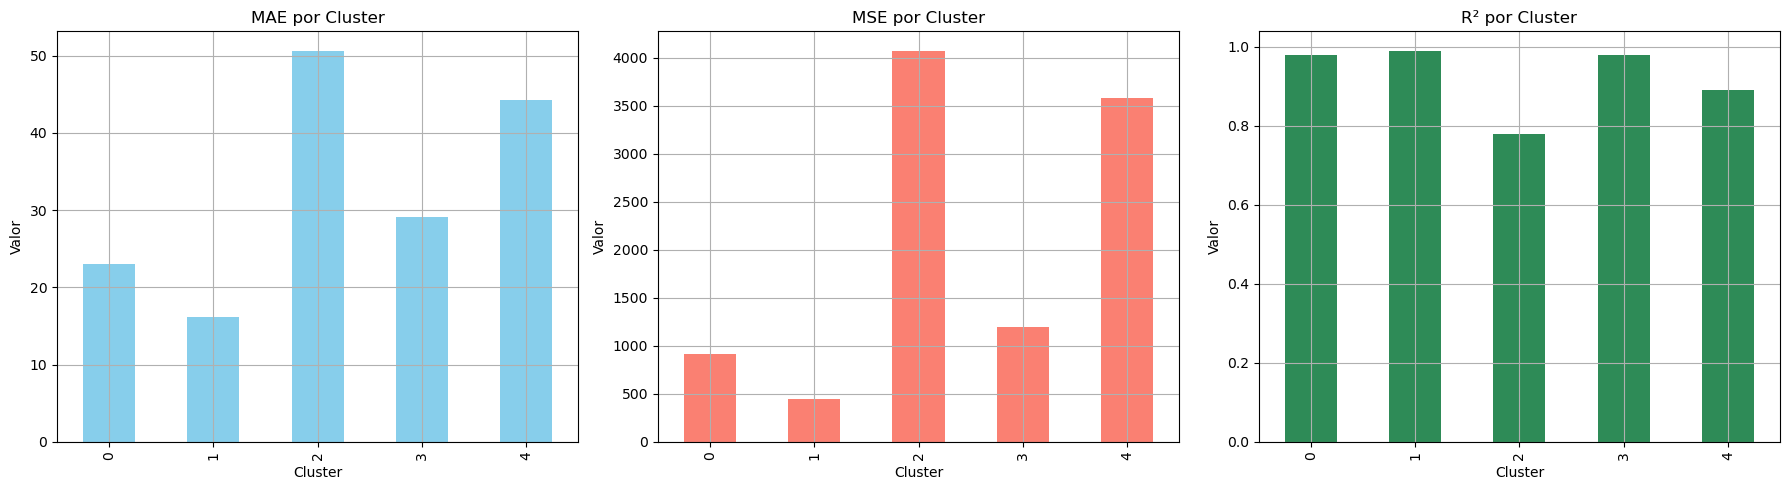

In [7]:
import matplotlib.pyplot as plt

# Representar MAE, MSE y R2 por cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df_resultados["MAE"].plot(kind='bar', ax=axes[0], color='skyblue', title="MAE por Cluster")
df_resultados["MSE"].plot(kind='bar', ax=axes[1], color='salmon', title="MSE por Cluster")
df_resultados["R2"].plot(kind='bar', ax=axes[2], color='seagreen', title="R² por Cluster")

for ax in axes:
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Valor")
    ax.grid(True)

plt.tight_layout()
plt.show()
